In [72]:
from __future__ import division
import numpy as np
import numba
%matplotlib inline

import cvxpy as cvx
import matplotlib.pyplot as plt
np.random.seed(1)

I = .1
N = 10000

@numba.jit(nopython=True)
def get_detections(N, I, deadtime=1):
    detections = 0
    misses = deadtime
    for i in range(N):
        if np.random.random() < (1-np.exp(-I)):
            # ignore first trial.
            # random chance of blocking.
            if i > 0 and misses >= deadtime:
                detections += 1
            misses = 0
        else:
            misses += 1
    return detections


# TODO
# fractional deadtime blocks a fraction of intensity in the trial 
# (eg deadtime=.2, have .2*I intensity in next trial)
# ignore the first trial (so min is 0 for high intensity)

In [73]:
# REFERENCE: do not change!
@numba.jit(nopython=True)
def get_count(N, I, QE=1):
    count = 0
    off = True
    for i in range(N):
        if np.random.random() < (1-np.exp(-I*QE)):
            if off:
                count += 1
            off = False
        else:
            off = True
    return count


TODO:

Why does real data level off so slowly?
What is the starting intensity for the real data?
How do I interpolate between integer deadtimes?


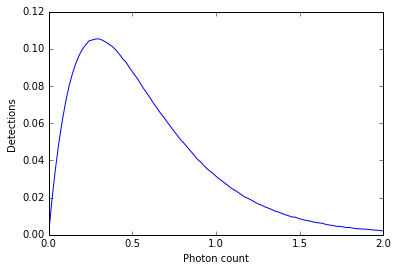

In [74]:
LEVELS = 100
intensities = np.linspace(0, 2.0, num=LEVELS)

def get_data_curve(N, intensities, deadtime, reps=25):
    results = np.zeros(intensities.shape)
    for i, intensity in enumerate(intensities):
        for rep in range(reps):
            results[i] += get_detections(N, intensity, deadtime)/reps
#         results[i] += get_count(N, intensity)/REPS
    return results/N

for deadtime in [3]:#np.linspace(0.5, 5, num=5):
    for QE in [1]:#np.linspace(.5, 1, num=10):
        results = get_data_curve(N, intensities*QE, deadtime, reps=100)
        plt.plot(intensities, results, label=deadtime)
plt.ylabel('Detections')
plt.xlabel('Photon count')
plt.show()

Analytic solution (I = intensity*PDP, k=deadtime/pulse interval): 

dark count probability = DCP
probability of no detection  P = exp(-I)*(1-DCP)
detection probability = (1-P)*P^k

Proof:
E[# of sequence occurences]/n = E[\sum_{i=0}^{k-1} # of sequence occurences starting at i + mk]/n
= \sum_{i=0}^{k-1} E[# of sequence occurences starting at i + mk]/n
= \sum_{i=0}^{k-1} p floor((n-i)/k)/n
<= \sum_{i=0}^{k-1} p (n-i)/(kn)
= p + p(k-1)/(2n)
converges to p as n->\infty

Expected number of sequences of k no detections then 1 detection
interpolate between integer k just by using non-integer k in formula. 


max at I = log(1+1/D)

0.148147243878
0.148148148148


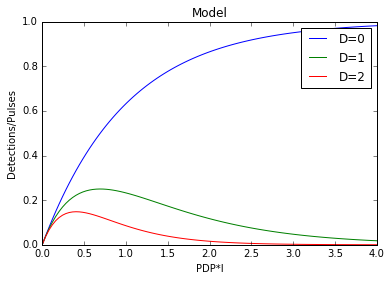

In [258]:
intensities = np.linspace(0, 4.0, num=LEVELS)
p = (1 - np.exp(-intensities))
analytic = p*(1-p)**2
print analytic.max()
max_I = np.log(1/2+1)
print (1 - np.exp(-max_I))*np.exp(-max_I)**2

plt.xlabel('PDP*I')
plt.ylabel('Detections/Pulses')
plt.plot(intensities, p, label='D=0')
plt.plot(intensities, p*(1-p), label='D=1')
plt.plot(intensities, analytic, label='D=2')
plt.legend()
plt.title('Model')

plt.xlabel('PDP*I')
plt.ylabel('Detections/Pulses')
# plt.savefig('model-example')
# plt.plot(intensities, results, label='empirical')
# plt.legend()

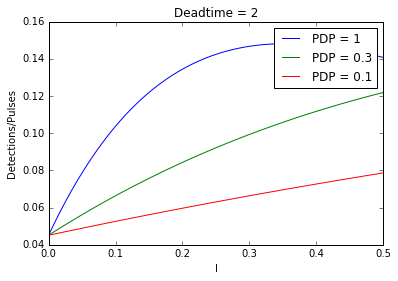

In [283]:
intensities = np.linspace(0, .5, num=LEVELS)
plt.xlabel('PDP*I')
plt.ylabel('Detections/Pulses')
DCP = 0.01
p = np.exp(-intensities)*(1-DCP)
plt.plot(intensities, p**2*(1-p), label='PDP = 1')
p = np.exp(-.3*intensities)*(1-DCP)
plt.plot(intensities, p**2*(1-p), label='PDP = 0.3')
p = np.exp(-.1*intensities)*(1-DCP)
plt.plot(intensities,p**2*(1-p), label='PDP = 0.1')
plt.legend()
plt.title('Deadtime = 2')

plt.xlabel('I')
plt.ylabel('Detections/Pulses')
# plt.savefig('model-example-PDP')
# plt.plot(intensities, results, label='empirical')
# plt.legend()

In [307]:
import scipy.io
data = scipy.io.loadmat('2016_10_26/1mhz_50ms_0_7vq_pulsed.mat')
pt_img = data['pt_grey_im'].mean(axis=(0,1))
args = np.argsort(pt_img)
pt_img = pt_img[args]
spad_img = data['spad_im'][::-1,:,args]

In [305]:
import scipy.io
data = scipy.io.loadmat('data_exp2_50MHz_5cm.mat')
pt_img = data['pt_img']
spad_img = data['spad_img'][::-1,:,:]

The pt_img/intensity values are the average values of the blue channel from a Point Grey camera (with a diffuser on the front) situated next to the SPAD array to observe the blue laser dot. 


We place the camera at sufficient distance from the laser dot so that the intensity values don't saturate at the highest laser intensity (that is, the camera pixel values are below 255).

[ 13.03393576  15.08755208  15.09994965  17.27020833  19.56427951
  22.39833507  25.06965278  27.70328299  29.61856944  31.58272222
  33.47155729  35.25564236  37.18138542  39.47909722  41.52552083
  43.41791667  45.46770486  47.16605729  48.38999826]


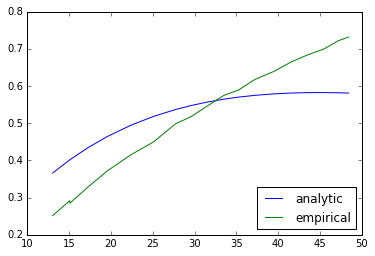

In [312]:


# intensities = np.linspace(1, 10.0, num=LEVELS)
real_int = pt_img[1:] - pt_img[0]
print real_int
p = (1 - np.exp(-(real_int +  0.0)*.04))
analytic = p*(1-p)**0.2
plt.plot(real_int, analytic, label='analytic')

PULSES = 50e-3*1e6
photon_counts = spad_img.sum(axis=0).T
# print photon_counts[1:,157]
plt.plot(real_int, photon_counts[1:,157]/PULSES, label='empirical')
plt.legend(loc='lower right')
plt.show()

# photon_counts[1:,:] -= photon_counts[0,:]
# plt.plot(pt_img[1:] - pt_img[0], photon_counts[1:,180]/PULSES)

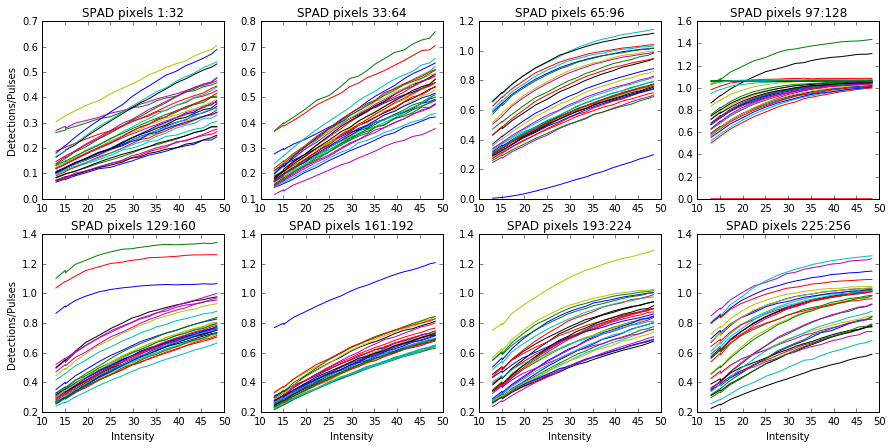

In [323]:
photon_counts = spad_img.sum(axis=0).T
plt.figure(figsize=(15,7))
for i in range(0,256,32):
    plt.subplot(2,4,i//32 + 1)
    if i in [0, 32*4]:
        plt.ylabel('Detections/Pulses')
    if i/32 > 3:
        plt.xlabel('Intensity')
    plt.title("SPAD pixels %i:%i" % (i+1,i+32))
    plt.plot(pt_img[1:] - pt_img[0], photon_counts[1:,i:i+32]/PULSES)
# plt.savefig('intensity-vs-detections-50MHz')
plt.show()

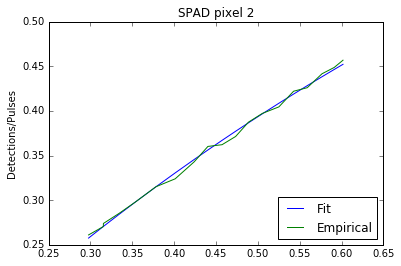

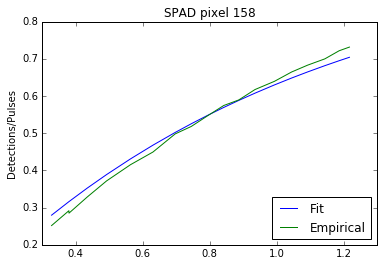

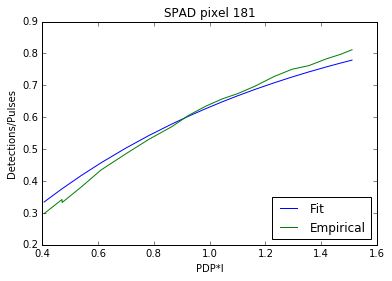

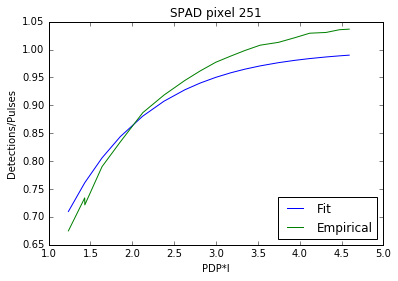

In [322]:
from scipy.optimize import curve_fit, bisect
plt.figure(figsize=(15,50))
# for idx, i in enumerate([1,157,180,250]): # 155
for i in range(256):
    x = (pt_img[1:] - pt_img[0]).ravel()
    y = photon_counts[1:,i]/PULSES # 180
    n = len(x)
    # mean = sum(x*hist)/n                   #note this correction
    # sigma = sum(hist*(x-mean)**2)/n        #note this correction

    def pdf(x, a, b, d):
        return (1 - np.exp(-a*(x + b)))*np.exp(-d*a*(x + b))
    p0 = [0.01,0.5,0.2]
    popt,pcov = curve_fit(pdf,x,y,p0=p0,bounds=(0,np.inf))
#     print popt
    a,b,d = popt
    x2 = a*(x+b)
    plt.subplot(64,8,i+1)
    plt.plot(x2, pdf(x, *popt), label='Fit')
    plt.plot(x2, y, label='Empirical')
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
#     plt.legend(loc='lower right')
#     plt.title('SPAD pixel %i' % (i+1))
#     plt.ylabel('Detections/Pulses')
    if idx > 1:
        plt.xlabel('PDP*I')
# plt.savefig('example-fits')

In [316]:
from scipy.optimize import curve_fit
# plt.figure(figsize=(15,7))
deadtimes = []

for i in range(256):
    x = (pt_img[1:] - pt_img[0]).ravel()
    y = photon_counts[1:,i]/PULSES # 180
    n = len(x)
    # mean = sum(x*hist)/n                   #note this correction
    # sigma = sum(hist*(x-mean)**2)/n        #note this correction

    def pdf(x, a, b, d):
        return (1 - np.exp(-a*(x + b)))*np.exp(-d*a*(x + b))
    p0 = [0.01,1.0,0.2]
    popt,pcov = curve_fit(pdf,x,y,p0=p0, bounds=(0,np.inf))
#     print popt
    a,b,d = popt
    deadtimes.append(d)
deadtimes = np.array(deadtimes)

9.33304036169e-16
0.0305401403714
3.49305908645e-45


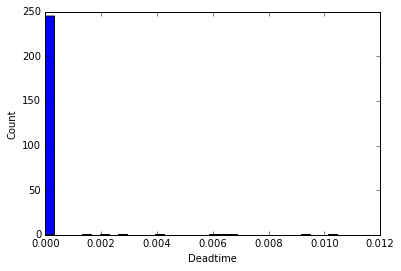

In [317]:

# plt.savefig('deadtime-hist')
args = np.argsort(deadtimes)
plt.hist(deadtimes[args][:-2], bins=32)
plt.ylabel('Count')
plt.xlabel('Deadtime')

print np.median(deadtimes)
print deadtimes.max()
print deadtimes.min()

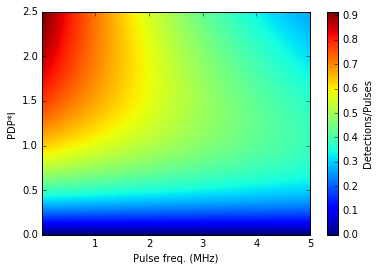

In [288]:
# Assume deadtime = 1/50MHz
intensities = np.linspace(0, 2.5, num=LEVELS)
freqs = np.linspace(0.01,5, num=LEVELS)
detections = np.zeros((LEVELS, LEVELS))
for i in range(LEVELS):
    for j in range(LEVELS):
        I = intensities[i]
        D = 5*freqs[j]/50
        detections[i,j] = (1-np.exp(-I))*np.exp(-D*I)
        
plt.imshow(detections, aspect='auto', origin='lower', 
           extent=(freqs.min(),freqs.max(),intensities.min(),intensities.max()))
plt.ylabel('PDP*I')
plt.xlabel('Pulse freq. (MHz)')
plt.colorbar(label='Detections/Pulses')
# plt.savefig('detections-freq-intensity')

In [ ]:
# Assume deadtime = 1/50MHz

intensities = np.linspace(0, 2.5, num=LEVELS)
freqs = np.linspace(1,100, num=LEVELS)
detections = np.zeros((LEVELS, LEVELS))
for i in range(LEVELS):
    for j in range(LEVELS):
        I = intensities[i]
        D = freqs[j]/50
        detections[i,j] = (1-np.exp(-I))*np.exp(-D*I)*D*1e6
        
plt.imshow(detections, aspect='auto', origin='lower', 
           extent=(freqs.min(),freqs.max(),intensities.min(),intensities.max()))
plt.ylabel('PDP*I')
plt.xlabel('Pulse freq. (MHz)')
plt.colorbar(label='Detections (Hz)')
# plt.savefig('detections-Hz')

In [ ]:
import scipy.io
data = scipy.io.loadmat('50mhz_pulsed.mat')
# print data
pt_grey_im = data['pt_grey_im']
spad_img = data['spad_im'][::-1,:,:]

pt_img = pt_grey_im.sum(axis=0).sum(axis=0)

photon_counts = spad_img.sum(axis=0).T
plt.figure(figsize=(15,7))
for i in range(0,256,32):
    plt.subplot(2,4,i//32 + 1)
    if i in [0, 32*4]:
        plt.ylabel('Detections/Pulses')
    if i/32 > 3:
        plt.xlabel('Intensity')
    plt.title("SPAD pixels %i:%i" % (i+1,i+32))
    plt.plot(pt_img[1:], photon_counts[1:,i:i+32]/PULSES)
plt.show()